In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier

import joblib

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader

import time
import random

In [2]:
%run '0_tools.ipynb'

In [3]:
train_np = np.load(f'{train_vect_path}updated_train_df.npy')

In [4]:
X = train_np[:, 2:]
Y = train_np[:, 0]

X = np.array(X)
Y = np.array(Y).astype(float)

In [5]:
torchX = torch.tensor(X, dtype=torch.float32)
torchY = torch.tensor(Y, dtype=torch.float32)

x_train, x_test, y_train, y_test = train_test_split(torchX, torchY, test_size=0.2, random_state=12345)

In [9]:
# start_col = 450
# pd.DataFrame(x_test).loc[:, start_col:start_col+19].head(20)

### Random Forest Classifier

In [8]:
load = True
save = False

In [9]:
rf = True
xt = False
gb = False

In [10]:
if (rf):
    if (not load):

        start_time = time.time()

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=12345)
        rf_classifier.fit(x_train, y_train)

        end_time = time.time()
        t = end_time - start_time

        print(f'RF Overall Accuracy is {str(rf_classifier.score(x_test, y_test)*100)[:5]}% | Train Time {str(t)[:6]}')

        if (save): joblib.dump(rf_classifier, f'{saved_model_path}random_forest_3_classifier.joblib')

    else:

        rf_classifier = joblib.load(f'{saved_model_path}random_forest_3_classifier.joblib')
        print(f'Overall Accuracy is {str(rf_classifier.score(x_test, y_test)*100)[:5]}%')

Overall Accuracy is 94.34%


[[2792   58   93]
 [  30 1682   10]
 [ 152   99 2902]]


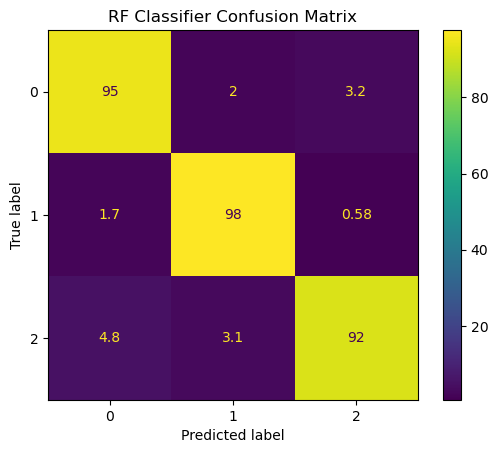

In [11]:
if (rf):

    test_preds = rf_classifier.predict(x_test).round()

    confusion_matrix = metrics.confusion_matrix(y_test.detach().numpy(), test_preds)
    
    print(confusion_matrix)
    
    cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_percent)

    cm_display.plot()

    plt.title('RF Classifier Confusion Matrix')
    plt.show()

### Extra Trees Classifier

In [14]:
if (xt):
    start = time.time()
                                        # parameters
    xt_classifier = ExtraTreesClassifier(n_estimators=50, max_depth=20, random_state=12345)
    xt_classifier.fit(x_train, y_train)
    end = time.time()

    traintime = (str(end - start)[:5])
    score = xt_classifier.score(x_test, y_test)

    print(f'Overall Accuracy is {score}% | Train Time {traintime}.')

In [15]:
if (xt):
    test_preds = xt_classifier.predict(x_test).round()

    confusion_matrix = metrics.confusion_matrix(y_test.detach().numpy(), test_preds)

    cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_percent)

    cm_display.plot()

    plt.title('XT Classifier Confusion Matrix')
    plt.show()

### Gradient Boosting

In [ ]:
start = time.time()
gb_clf = GradientBoostingClassifier(n_estimators=50, max_depth=8, random_state=12345)
gb_clf.fit(x_train, y_train)
end = time.time()
print(f'Overall Accuracy {gb_clf.score(x_test, y_test)}% | Train Time {end - start}.')

### Neural Network

In [14]:
class NN_Sentiment_Analysis(nn.Module):
    def __init__(self, input_dim):
        super(NN_Sentiment_Analysis, self).__init__()
        
        self.model = nn.Sequential(
            
            nn.Linear(input_dim, int(input_dim/2)),
            nn.ReLU(),
            
            nn.Linear(int(input_dim/2), int(input_dim/4)),
            nn.ReLU(),
            
            nn.Linear(int(input_dim/4), int(input_dim/8)),
#             nn.ReLU(),
            
#             nn.Linear(int(input_dim/8), int(input_dim/16)),
#             nn.ReLU(),
            
            nn.Dropout(p=0.1),
            
            nn.Linear(int(input_dim/8), 5),
            
            nn.Linear(5, 1)
        
        )
        
    def forward(self, x):
                
        return self.model(x)

In [15]:
#create instance of CNN Image Classifier
classify = NN_Sentiment_Analysis(X.shape[1]).to('cpu')

#optimizer, lr = learning rate
opt = Adam(classify.parameters(), lr=1e-3)

# total loss function
loss_fn = nn.MSELoss()

In [16]:
classify(x_test).shape

torch.Size([7036, 1])

In [17]:
num_epochs = 10

In [18]:
train_time = True
updateModel = False

In [ ]:
# Training flow
if (train_time):
    
    train = []
    for i in range(len(x_train)):
        train.append((x_train[i], y_train[i]))
        
    trainloader = DataLoader(train, 256)

    for epoch in range(1, num_epochs+1):
        
        epoch_start_time = time.time()
        
        for batch in trainloader:
            
            x,y = batch 
            x, y = x.to('cpu'), y.to('cpu') 
            yhat = classify(x).squeeze()
            
#             print(yhat)
#             print(y)

            loss = loss_fn(yhat, y)
    
#             print(loss)
                                
            #backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        epoch_preds = classify(x_test).round()
        
        correct = 0
        total = 0
        for pred_i in range(len(epoch_preds)):
            if (epoch_preds[pred_i] == y_test[total]): correct+=1
            total+=1
            
        accuracy = (correct/total)
        
        epoch_end_time = time.time()
        
        # print loss for every so many epochs
        if (epoch%1==0):
            print(f"Epoch {epoch} | Loss {loss.item()} | Test Accuracy {str(accuracy*100)[:5]}%", end = ' ') 
            print(f"| {str(epoch_end_time-epoch_start_time)[:5]} seconds")

In [124]:
correct=0
total=0

# predictions
predictions = classify(x_test).round()

# make predictions higher than 5 just 5, lower than 1 just 1
# also calculating accuracy
for pred_index in range(len(predictions)):
    pred = predictions[pred_index]

    while (pred > 5): 
        predictions[pred_index]-=1
        pred = predictions[pred_index]
        
    while (pred < 1): 
        predictions[pred_index]+=1
        pred = predictions[pred_index]
        
    pred = predictions[pred_index]
#     print(int(pred))
    
    if (pred == y_test[total]): correct+=1
    total+=1
    
print(f'Test Accuracy: {str((correct/total)*100)[:6]}% | {correct}/{total}')

Test Accuracy: 37.672% | 327/868


Text(0.5, 1.0, 'Distribution of Test Set True Ratings')

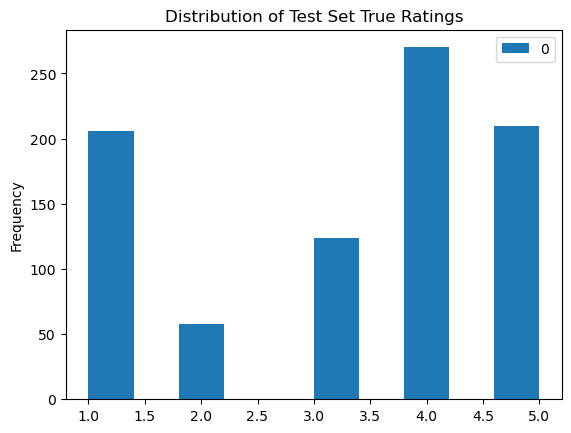

In [125]:
np_y = np.array(y_test)
df_y = pd.DataFrame(np_y)
df_y.plot.hist()
plt.title('Distribution of Test Set True Ratings')

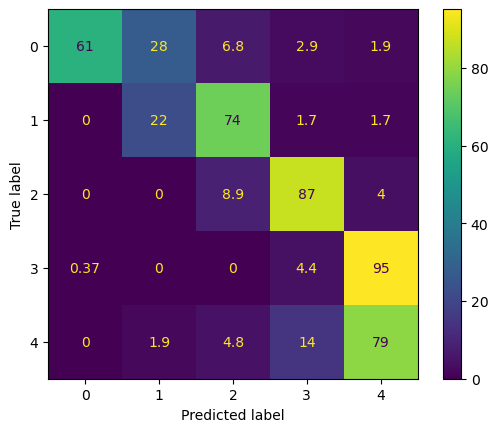

In [126]:
confusion_matrix = metrics.confusion_matrix(y_test.detach().numpy(), predictions.detach().numpy())

cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_percent)

cm_display.plot()
# classes = unique_labels(y_test, predictions.detach().numpy())

plt.show()

In [48]:
# confusion_matrix